In [100]:
using TVC, DifferentialEquations, SCPToolbox, Plots, Revise, LinearAlgebra

# Specify Parameters

In [101]:
veh = RocketParameters()
atmos = Atmosphere()
traj = RocketTrajectoryParameters();

mdl = RocketProblem(veh, atmos, traj)

RocketProblem
  veh: RocketParameters{Float64, Diagonal{Float64, Vector{Float64}}}
  atmos: Atmosphere
  traj: RocketTrajectoryParameters{Float64}


In [102]:
servoΔt = 0.02 # Servo step rate
x_0 = [traj.r0; traj.v0; traj.q0; traj.ω0][[veh.id_r; veh.id_v; veh.id_quat; veh.id_ω]];

# Solve Optimal Trajectory

In [103]:
solution = solveProblem(mdl);

# Specify Controller

In [104]:
function control(x, p, t, servoΔt)
    veh = p.veh
    tₘ = motorTime(t, p.MotorIgnitionTime)
    sol = p.solution

    td = tₘ - tₘ % servoΔt

    if 0 ≤ tₘ ≤ veh.BurnTime
        desired_tvc = sample(solution.xc, td / veh.BurnTime)[veh.id_T]
        desired_roll = sample(solution.uc, td / veh.BurnTime)[veh.id_roll]
    else
        desired_tvc = zeros(3)
        desired_roll = 0.
    end

    return Actuator(x, p, t, desired_tvc, desired_roll)
end

function control(x, p, t)
    veh = p.veh
    tₘ = motorTime(t, p.MotorIgnitionTime)
    sol = p.solution

    if 0 ≤ tₘ ≤ veh.BurnTime
        desired_tvc = sample(solution.xc, tₘ / veh.BurnTime)[veh.id_T]
        desired_roll = sample(solution.uc, tₘ / veh.BurnTime)[veh.id_roll]
    else
        desired_tvc = zeros(3)
        desired_roll = 0.
    end

    return Actuator(x, p, t, desired_tvc, desired_roll)
end

control (generic function with 2 methods)

In [105]:
function Actuator(x, p, t, desired_tvc, desired_roll) # Model of TVC
    veh = p.veh
    tₘ = motorTime(t, p.MotorIgnitionTime)

    Thrust = desired_tvc * veh.Thrust(tₘ)
    torque = veh.MomentArm(tₘ) × Thrust + [0; 0; desired_roll]
    
    return (force=Thrust, torque=torque)
end

Actuator (generic function with 1 method)

# Simulate controller using optimal trajectory

## Continuous Controller

In [106]:
using Parameters

@with_kw struct ODEParameters{R, V}
    veh::RocketParameters = RocketParameters()
    atmos::Atmosphere = Atmosphere()
    traj::RocketTrajectoryParameters = RocketTrajectoryParameters()

    Aero::Bool = true
    wind::V = zeros(3)

    solution::SCPSolution

    MotorIgnitionTime::R = 0.0
    Control = zeros(3)
end

ODEParameters

In [107]:
MotorIgnitionTime = solution.p[veh.id_tcoast]

tspan = (0, solution.p[veh.id_tcoast] + veh.BurnTime + 10.0)

p = ODEParameters(veh=veh, atmos=atmos, traj=traj, solution=solution, MotorIgnitionTime=MotorIgnitionTime, Control=(x, p, t) -> control(x, p, t))

prob = ODEProblem(f!, x_0, tspan, p)

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cb)

retcode: Terminated
Interpolation: specialized 7th order lazy interpolation, specialized 3rd order "free" stiffness-aware interpolation
t: 619-element Vector{Float64}:
 0.0
 0.03228476127381208
 0.05561032069265364
 0.08341759705113916
 0.11230389383501302
 0.1459023840063855
 0.15773363140088867
 0.1673484968487605
 0.17972564319240653
 0.19281748533792503
 ⋮
 3.3810690340284797
 3.384782013674102
 3.388269168771598
 3.3887081833109574
 3.3894292593256106
 3.389434611537959
 3.3894374008282524
 3.3894377157445907
 3.3894377157445907
u: 619-element Vector{Vector{Float64}}:
 [20.0, -4.0, 30.0, 4.0, -3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.129049075094763, -4.096786806321072, 29.994889284917996, 3.994427528094438, -2.9958206460708285, -0.31660223207361143, 0.999999976297274, -0.00013063675806615366, -0.00017418234408820513, 6.055664218223397e-23, -0.01616511528924533, -0.02155348705232711, 3.945088684510222e-20]
 [20.222174352535777, -4.166630764401832, 29.98483658573593, 3.990

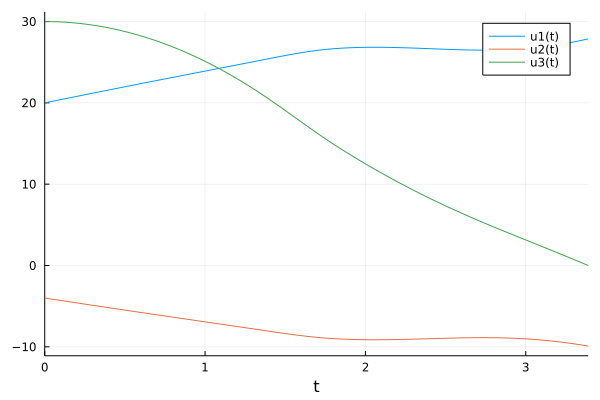

In [108]:
println(sol.prob.p.MotorIgnitionTime)
println(sol.t[end] - sol.prob.p.MotorIgnitionTime)
plot(sol, vars=1:3)

## Discrete Controller

In [109]:
MotorIgnitionTime = solution.p[veh.id_tcoast]

tspan = (0, solution.p[veh.id_tcoast] + veh.BurnTime + 10.0)
p = ODEParameters(veh=veh, atmos=atmos, traj=traj, solution=solution, MotorIgnitionTime=MotorIgnitionTime, Control=(x, p, t) -> control(x, p, t, servoΔt))

prob = ODEProblem(f!, x_0, tspan, p)

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

saved_values = SavedValues(Float64, AbstractVector{Float64})
scb = SavingCallback((x, t, integrator) -> [integrator.p.Control(x, integrator.p, t).force; integrator.p.Control(x, integrator.p, t).torque[3]], saved_values, save_everystep = true)

cbs = CallbackSet(cb, scb)

sol = DifferentialEquations.solve(prob, reltol=1e-12, abstol=1e-12, callback=cbs)

retcode: Terminated
Interpolation: specialized 9th order lazy interpolation, specialized 4rd order "free" stiffness-aware interpolation
t: 8643-element Vector{Float64}:
 0.0
 0.0007325575214241266
 0.0011812471423607485
 0.001688264532955205
 0.0020735310656607602
 0.002400026906714229
 0.003054850077079668
 0.0034645854484548697
 0.004058881320195521
 0.004487445286920232
 ⋮
 3.39192241456133
 3.3919246347319625
 3.3919249873453996
 3.3919252018739674
 3.391925208975527
 3.3919252094546914
 3.391925209587895
 3.391925209604031
 3.391925209604031
u: 8643-element Vector{Vector{Float64}}:
 [20.0, -4.0, 30.0, 4.0, -3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.002930183726157, -4.002197637794617, 29.999997368701905, 3.9998734328415693, -2.999905074631177, -0.00718386752267553, 0.9999999999999937, -6.74637032226913e-8, -8.99516042969217e-8, 3.8972419512248485e-31, -0.00036835816631704623, -0.0004911442217560615, 0.0]
 [20.004724868029925, -4.003543651022443, 29.999993158235373, 3.99979

In [110]:
println(sol.prob.p.MotorIgnitionTime)
println(sol.t[end] - sol.prob.p.MotorIgnitionTime)

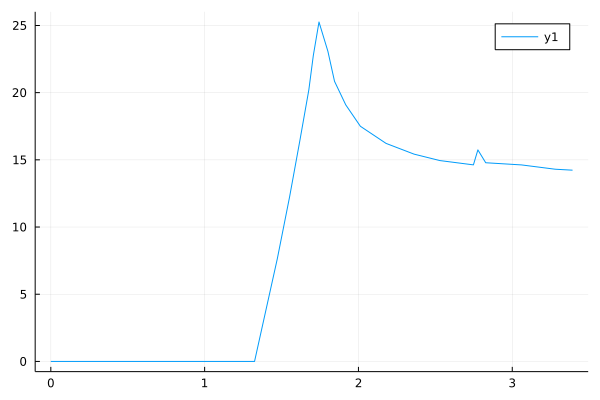

In [111]:
plot(saved_values.t, reduce(hcat, saved_values.saveval)[3, :])
# plot!(saved_values.t, mapreduce(t -> control(x, p, t, servoΔt), hcat, saved_values.t)[1, :])
# plot!(saved_values.t, mapreduce(t -> control(motorTime(t, MotorIgnitionTime), veh, solution), hcat, saved_values.t)[1, :])

# MPC Controller

In [112]:
using Printf

function mpc!(integrator)
    veh = integrator.p.veh
    atmos = integrator.p.atmos

    x = integrator.u

    r = x[veh.id_r]
    v = x[veh.id_v]
    quat = x[veh.id_quat]
    ω = x[veh.id_ω]

    if integrator.t >= integrator.p.MotorIgnitionTime[]
        traj = RocketTrajectoryParameters(r0=r, v0=v, q0=quat, ω0=ω, t0=integrator.t - integrator.p.MotorIgnitionTime[], MotorFired=true)
    else
        traj = RocketTrajectoryParameters(r0=r, v0=v, q0=quat, ω0=ω)
    end

    mdl = RocketProblem(veh, atmos, traj)
    tmpSolution = solveProblem(mdl)

    if tmpSolution.status == @sprintf("%s", SCP_SOLVED)
        integrator.p.solution[] = tmpSolution
        
        if !traj.MotorFired
            integrator.p.MotorIgnitionTime[] = integrator.t + integrator.p.solution[].p[veh.id_tcoast]
        end
    end

    print(integrator.t + integrator.p.solution[].p[veh.id_tcoast])
end

mpccb = PeriodicCallback(mpc!, 1.);

In [113]:
import TVC: motorTime
function motorTime(t, MotorIgnitionTime)
    return t - MotorIgnitionTime[]
end


motorTime (generic function with 2 methods)

In [114]:
function control(t, Rocket, solution, servoΔt) # discretise TVC based on servo step rate
    td = t - t % servoΔt
    if 0 ≤ t ≤ Rocket.BurnTime
        return vcat(sample(solution[].xc, td / Rocket.BurnTime)[Rocket.id_T] * Rocket.Thrust(t), sample(solution[].uc, t / Rocket.BurnTime)[Rocket.id_roll])
    else
        return zeros(4)
    end
end

control (generic function with 2 methods)

In [115]:
MotorIgnitionTime = Ref(solution.p[veh.id_tcoast])

tspan = (0., solution.p[veh.id_tcoast] + veh.BurnTime + 10.0)
test = Ref(solution)
p = (veh=veh, atmos=atmos, wind=randn(3) * 5, MotorIgnitionTime=MotorIgnitionTime, solution=test, Control=(x, p, t) -> control(motorTime(t, MotorIgnitionTime), veh, test, servoΔt))

prob = ODEProblem(f!, x_0, tspan, p)

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

saved_values = SavedValues(Float64, Float64)
scb = SavingCallback((u, t, integrator) -> integrator.p.MotorIgnitionTime[], saved_values, save_everystep = true)

cbs = CallbackSet(cb, mpccb, scb);

In [116]:
sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cbs)

ErrorException: type Array has no field torque

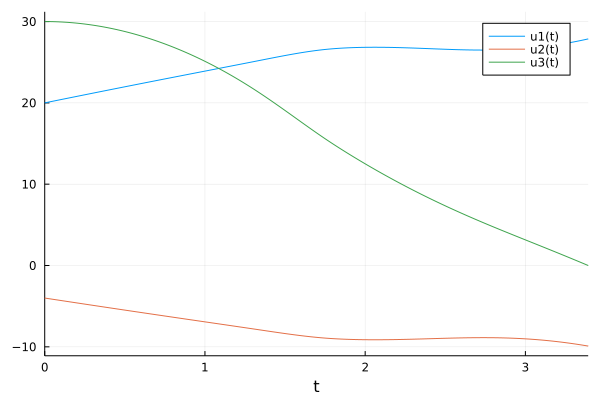

In [117]:
println(sol.prob.p.MotorIgnitionTime[])
println(sol.t[end] - sol.prob.p.MotorIgnitionTime[])
Plots.plot(sol, vars=1:3)

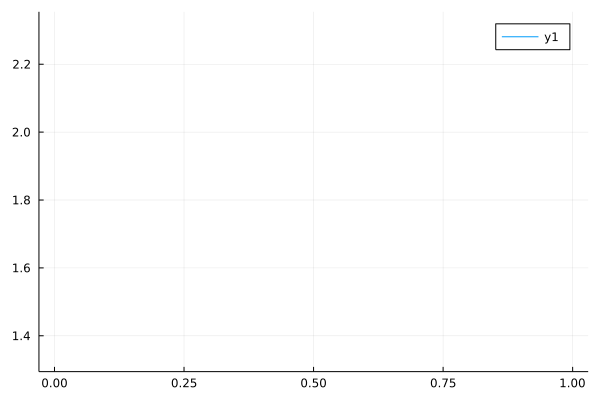

In [118]:
plot(saved_values.t, saved_values.saveval)